In [122]:
import os
from IPython.display import display, clear_output
from xgboost import XGBRegressor

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.decomposition import PCA

from statsmodels.tsa.stattools import adfuller, kpss, coint
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import random
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
plt.style.use('ggplot')
pd.options.display.float_format = '{:.4f}'.format

os.chdir('/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA')
os.getcwd()

'/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA'

In [86]:
# Дата, которая разделяет тренировочную и тестовую выборки, чтобы делить выборки для всех моделей
train_test_split_date = '2022-06-01'

# импортируем данные и делим их по дате
df = pd.read_csv('final_regional_df/infl_Российская_Федерация.csv')
df['date'] = pd.date_range(start='2014-01-01', periods=len(df), freq='ME')
df.drop(['unemp', 'paid_services'], axis=1, inplace=True)

df_train = df[df['date'] < train_test_split_date].copy()
df_test = df[df['date'] >= train_test_split_date].copy()

# Делим Датафреймы на эндогенные и экзогенные переменные
y_train = df_train['inflation']
y_test = df_test['inflation']
df_train.drop(['inflation', 'date'], axis=1, inplace=True)
df_test.drop(['inflation', 'date'], axis=1, inplace=True)
X_train = df_train.copy()
X_test = df_test.copy()

dummies_train = pd.DataFrame(0, index=y_train.index, columns=['outlier_12', 'outlier_98'])
dummies_test = pd.DataFrame(0, index=y_test.index, columns=['outlier_12', 'outlier_98'])
dummies_train.iloc[12, 0] = 1  # Дамми для индекса 12
dummies_train.iloc[98, 1] = 1  # Дамми для индекса 98

# Добавляем дамми-переменные к экзогенным факторам
X_train = pd.concat([X_train, dummies_train], axis=1)
X_test = pd.concat([X_test, dummies_test], axis=1)

## ARDL


Алтайский_край
                                                  ARDL Model Results                                                  
Dep. Variable:                                                      inflation   No. Observations:                  101
Model:             ARDL(2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0)   Log Likelihood                 -21.604
Method:                                                       Conditional MLE   S.D. of innovations              0.301
Date:                                                        Fri, 09 May 2025   AIC                             89.208
Time:                                                                19:04:37   BIC                            148.896
Sample:                                                                     2   HQIC                           113.358
                                                                          101                                         
                        coef    s

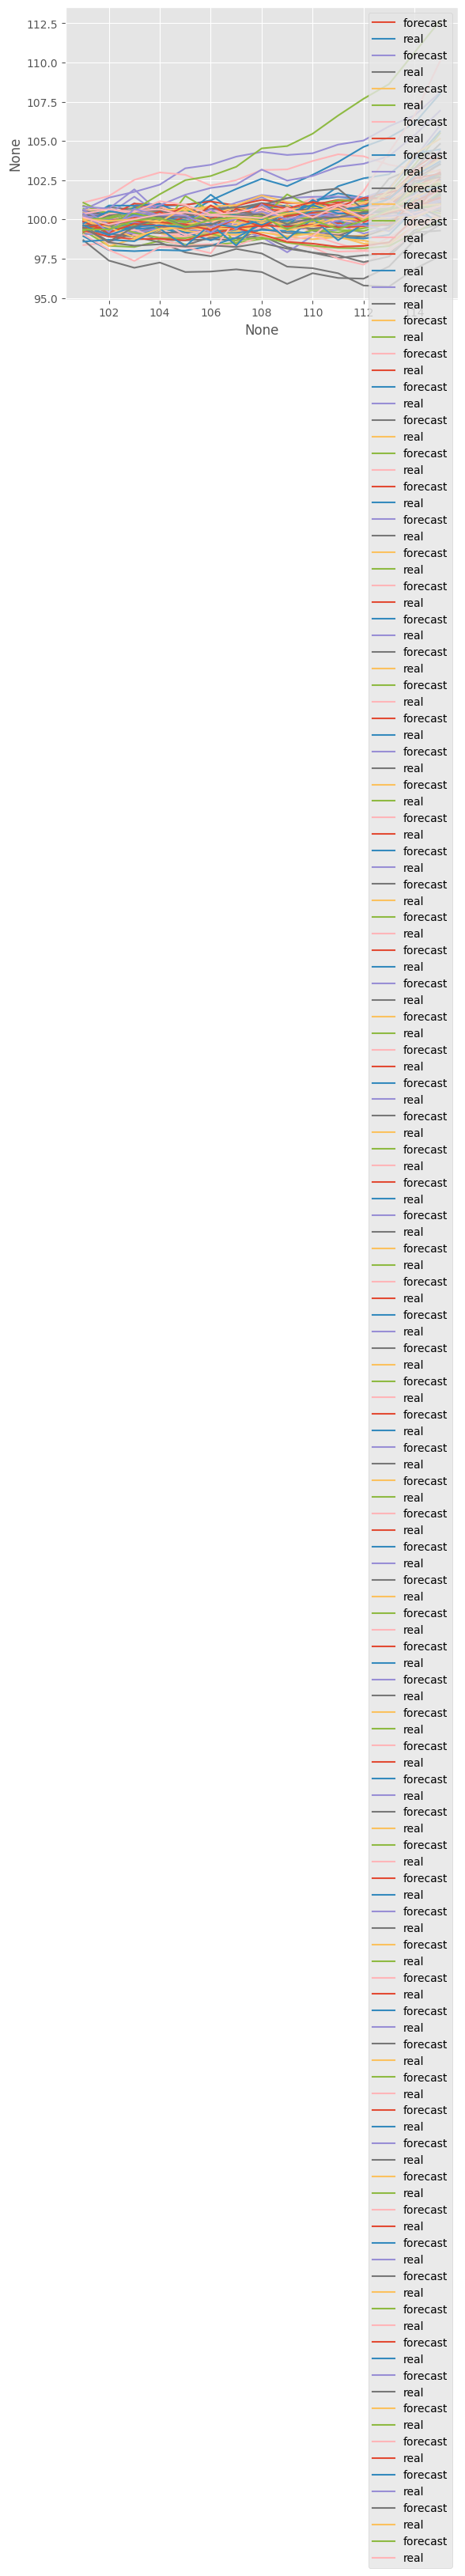

In [137]:
# Дата, которая разделяет тренировочную и тестовую выборки, чтобы делить выборки для всех моделей
train_test_split_date = '2022-06-01'
file_names = os.listdir('/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA/final_regional_df')
source_path = os.path.join(os.getcwd(), 'final_regional_df')

for file_name in file_names:
    try:        
        def reg_statistics():
                forecast = res.forecast(steps=len(y_test), exog=X_test[:len(y_test)])
                mse = mean_squared_error(y_test, forecast)
                tss = np.sum((y_test - np.mean(y_test))**2)
                rss = np.sum(res.resid**2)
                r_squared = 1 - (rss / tss)
                n = len(y_test)  # Количество наблюдений
                k = len(res.params) - 1  # Количество предикторов (без константы)
                adj_r_squared = 1 - ( (1 - r_squared) * (n - 1) / (n - k - 1) )
                sb.lineplot(x=y_test.index, y=forecast, label='forecast');
                sb.lineplot(x=y_test.index, y=y_test, label='real');
                print(res.summary())
                print(f"Adjusted R-squared: {adj_r_squared:.2f}")
                print(f"MSE: {mse:.3f}")
                
        def get_max_lags_dict(df_result, p_value_threshold=0.05):
            df = df_result.copy()
            # Получаем уникальные регрессоры (исключая 'inflation')
            regressors = [col for col in df['regr'].unique() if col != 'inflation']
            # Создаем словарь с максимальными лагами только для значимых коэффициентов (p-value <= 0.05)
            max_lags_dict = {}
            for regr in regressors:
                # Находим значимые строки для текущего регрессора (p-value <= 0.05)
                regr_data = df[(df['regr'] == regr) & (df['p-value'] <= 0.05)]
                if not regr_data.empty:
                    # Берем максимальный значимый лаг
                    max_lag = regr_data['lag'].max()
                else:
                    # Если нет значимых коэффициентов, ставим 0
                    max_lag = 0
                max_lags_dict[regr] = max_lag

            # Добавляем регрессоры, которых нет в данных, но которые нужны в словаре
            required_regressors = X_train.columns
            for regr in required_regressors:
                if regr not in max_lags_dict:
                    max_lags_dict[regr] = 0

            max_lags_dict = {k: max_lags_dict[k] for k in max_lags_dict}
            max_lags_dict = {k: int(v) if isinstance(v, str) else v for k, v in sorted(max_lags_dict.items())}
            
            return max_lags_dict

        df = pd.read_csv(f'{os.path.join(source_path, file_name)}').reset_index(drop=True).dropna()
        df['date'] = pd.date_range(start='2014-01-01', periods=len(df), freq='ME')
        df.drop(['unemp', 'paid_services'], axis=1, inplace=True)

        df_train = df[df['date'] < train_test_split_date].copy()
        df_test = df[df['date'] >= train_test_split_date].copy()

        # Делим Датафреймы на эндогенные и экзогенные переменные
        y_train = df_train['inflation'].copy() * 100
        y_test = df_test['inflation'].copy() * 100
        df_train.drop(['inflation', 'date'], axis=1, inplace=True)
        df_test.drop(['inflation', 'date'], axis=1, inplace=True)
        X_train = df_train.copy()
        X_test = df_test.copy()

        dummies_train = pd.DataFrame(0, index=y_train.index, columns=['outlier_12', 'outlier_98'])
        dummies_test = pd.DataFrame(0, index=y_test.index, columns=['outlier_12', 'outlier_98'])
        dummies_train.iloc[12, 0] = 1  # Дамми для индекса 12
        dummies_train.iloc[98, 1] = 1  # Дамми для индекса 98

        # Добавляем дамми-переменные к экзогенным факторам
        X_train = pd.concat([X_train, dummies_train], axis=1)
        X_test = pd.concat([X_test, dummies_test], axis=1)

        res = ARDL(y_train, 2, X_train, order=2, trend='n').fit()
        df_result_region = pd.concat([res.params, res.pvalues], axis=1).reset_index()
        df_result_region.columns = ['regr', 'coef', 'p-value']
        df_result_region['lag'] = df_result_region['regr'].apply(lambda x: re.findall(r'[0-9]', x)[-1])
        df_result_region['regr'] = df_result_region['regr'].apply(lambda x: re.sub(r'.L\d+', '', x))
        df_result_region = df_result_region.loc[df_result_region['p-value'] < 0.3]
        
        res = ARDL(
            y_train,
            2,
            X_train,
            get_max_lags_dict(df_result_region),
            trend='n'
        ).fit()
        print(file_name[5:-4])
        reg_statistics()
    except Exception as e:
        print(f"❌ Error in {file_name}: {str(e)}")
        continue

❌ Error in infl_Калужская_область.csv: Prediction must have `end` after `start`.


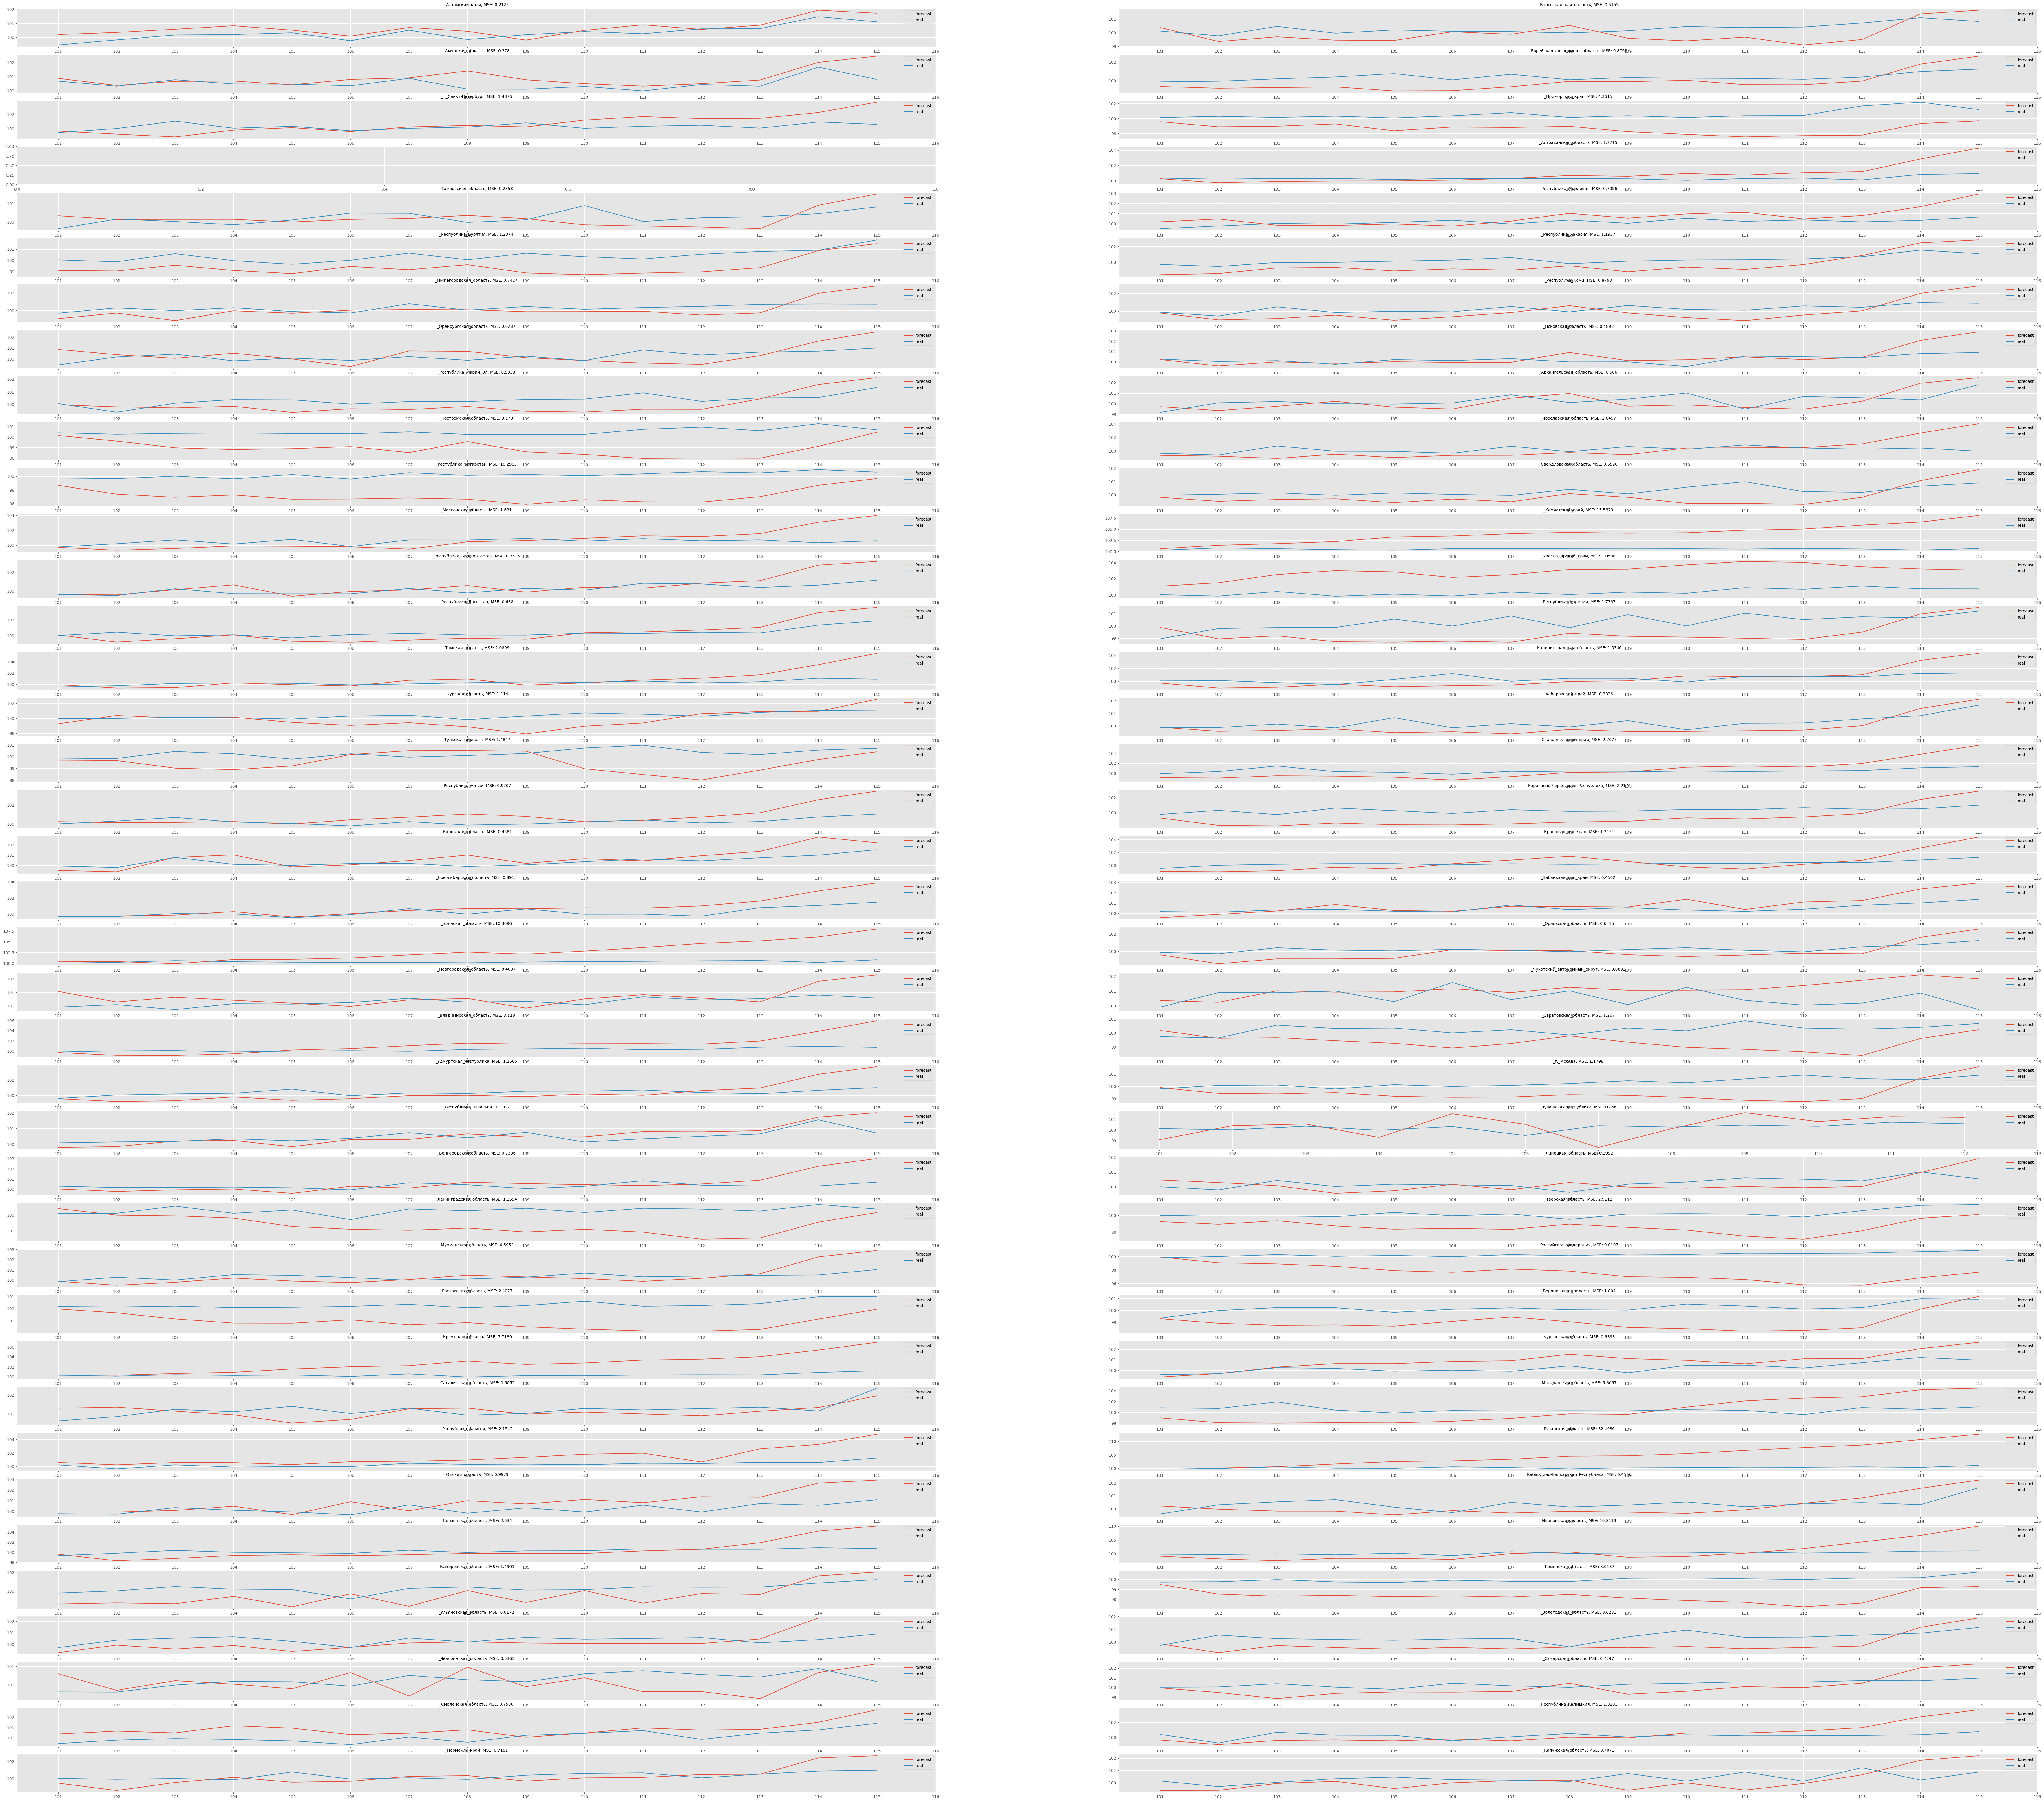

In [169]:
rows = 39
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(90, 80), dpi=100)

for i in range(len(file_names)):
    try: 
        row = i // cols
        col = i % cols
        df = pd.read_csv(f'{os.path.join(source_path, file_names[i])}').reset_index(drop=True).dropna()
        df['date'] = pd.date_range(start='2014-01-01', periods=len(df), freq='ME')
        df.drop(['unemp', 'paid_services'], axis=1, inplace=True)

        df_train = df[df['date'] < train_test_split_date].copy()
        df_test = df[df['date'] >= train_test_split_date].copy()

        # Делим Датафреймы на эндогенные и экзогенные переменные
        y_train = df_train['inflation'].copy() * 100
        y_test = df_test['inflation'].copy() * 100
        df_train.drop(['inflation', 'date'], axis=1, inplace=True)
        df_test.drop(['inflation', 'date'], axis=1, inplace=True)
        X_train = df_train.copy()
        X_test = df_test.copy()

        dummies_train = pd.DataFrame(0, index=y_train.index, columns=['outlier_12', 'outlier_98'])
        dummies_test = pd.DataFrame(0, index=y_test.index, columns=['outlier_12', 'outlier_98'])
        dummies_train.iloc[12, 0] = 1  # Дамми для индекса 12
        dummies_train.iloc[98, 1] = 1  # Дамми для индекса 98

        # Добавляем дамми-переменные к экзогенным факторам
        X_train = pd.concat([X_train, dummies_train], axis=1)
        X_test = pd.concat([X_test, dummies_test], axis=1)

        res = ARDL(y_train, 2, X_train, order=2, trend='n').fit()
        df_result_region = pd.concat([res.params, res.pvalues], axis=1).reset_index()
        df_result_region.columns = ['regr', 'coef', 'p-value']
        df_result_region['lag'] = df_result_region['regr'].apply(lambda x: re.findall(r'[0-9]', x)[-1])
        df_result_region['regr'] = df_result_region['regr'].apply(lambda x: re.sub(r'.L\d+', '', x))
        df_result_region = df_result_region.loc[df_result_region['p-value'] < 0.3]
        
        res = ARDL(
            y_train,
            2,
            X_train,
            get_max_lags_dict(df_result_region),
            trend='n'
        ).fit()
        forecast = res.forecast(steps=len(y_test), exog=X_test[:len(y_test)])
        mse = mean_squared_error(y_test, forecast)
        axes[row, col].plot(y_test.index, forecast, label='forecast');
        axes[row, col].plot(y_test.index, y_test, label='real');        
        axes[row, col].set_xticks(np.arange(len(y_train), len(y_train)+len(y_test)+1, 1))
        axes[row, col].set_title(f'{file_names[i][4:-4]}, MSE: {round(mse,4)}', fontsize=10)
        axes[row, col].legend()
    except Exception as e:
        print(f"❌ Error in {file_name}: {str(e)}")
        continue
plt.savefig('result/ARDL_predict.pdf')

In [174]:
res = ARDL(
        y_train,
        2,
        X_train,
        2,
        trend='n'
    ).fit()
pd.concat([res.params, res.pvalues],axis=1)

0      1
inflation.L1       0.4874 0.0179
inflation.L2      -0.0928 0.6777
Brent.L0           0.0092 0.4362
Brent.L1           0.0046 0.7272
Brent.L2           0.0127 0.3446
MIACR.L0           0.6702 0.0000
MIACR.L1          -0.7226 0.0007
MIACR.L2           0.0959 0.5407
obligates.L0      -0.1037 0.2480
obligates.L1      -0.0985 0.4708
obligates.L2       0.1240 0.3872
M2.L0             11.6492 0.2008
M2.L1             -8.5833 0.3102
M2.L2             -2.5892 0.7759
money_income.L0   -1.6431 0.6962
money_income.L1    2.3314 0.6602
money_income.L2    0.0500 0.9902
trade_turnover.L0  2.0070 0.4991
trade_turnover.L1  2.0057 0.5964
trade_turnover.L2 -0.2879 0.9260
debt_firms.L0     -1.9292 0.6431
debt_firms.L1     -1.7168 0.6926
debt_firms.L2     -1.5168 0.6621
PCA_1.L0          -0.0977 0.0732
PCA_1.L1           0.0032 0.9651
PCA_1.L2           0.0013 0.9816
PCA_2.L0          -0.0471 0.7341
PCA_2.L1           0.1436 0.2823
PCA_2.L2           0.0271 0.8030
PCA_3.L0          -0.3011 0.0104
PCA_3.L1           0.3168 0.0324
PCA_3.L2           0.0149 0.9150
PCA_4.L0           0.1025 0.2549
PCA_4.L1          -0.0783 0.4443
PCA_4.L2           0.0825 0.4019
PCA_5.L0           0.0483 0.4556
PCA_5.L1          -0.0963 0.2285
PCA_5.L2          -0.0326 0.6798
PCA_6.L0           0.2700 0.0793
PCA_6.L1          -0.1788 0.3017
PCA_6.L2           0.0606 0.7205
PCA_7.L0           0.1476 0.1920
PCA_7.L1          -0.0504 0.5869
PCA_7.L2           0.0928 0.2844
PCA_8.L0          -0.0728 0.5314
PCA_8.L1           0.0351 0.7640
PCA_8.L2           0.0261 0.7962
PCA_9.L0          -0.0711 0.4323
PCA_9.L1          -0.1832 0.0691
PCA_9.L2           0.1603 0.0891
outlier_12.L0      0.1037 0.9290
outlier_12.L1     -0.4915 0.6007
outlier_12.L2     -0.8588 0.1906
outlier_98.L0     -0.3358 0.8993
outlier_98.L1      0.7706 0.7223
outlier_98.L2      1.4155 0.1801

## XGBoost


### Без сглаживания шоков без PCA


Mean Squared Error: 0.0314
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


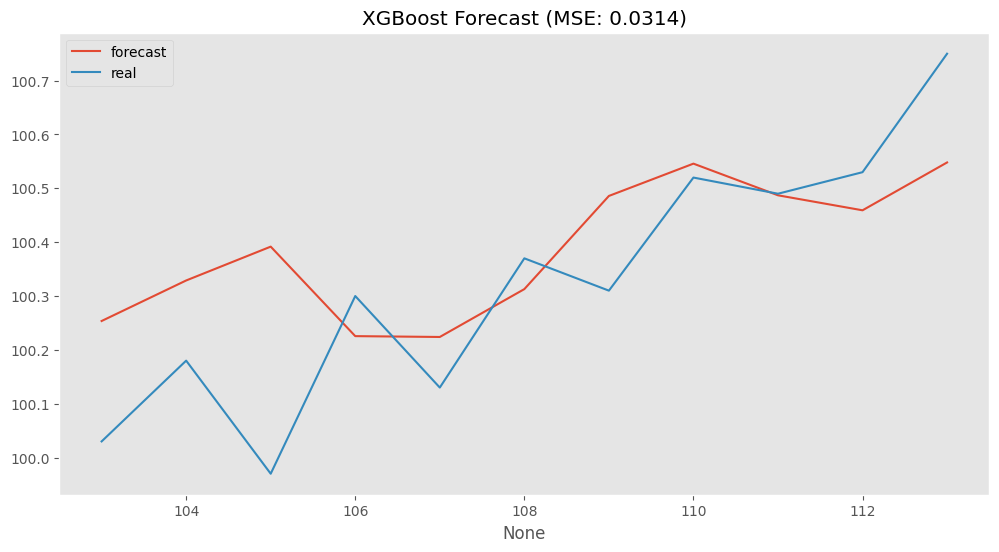

In [16]:
df_1 = df.drop(['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4',	'PCA_5',
               'PCA_6', 'PCA_7', 'PCA_8'], axis=1, inplace=False)
df_train = df_1[df_1['date'] < train_test_split_date].copy()
df_test = df_1[df_1['date'] >= train_test_split_date].copy()
y_train = df_train['inflation']
y_test = df_test['inflation']
df_train.drop(['inflation', 'date'], axis=1, inplace=True)
df_test.drop(['inflation', 'date'], axis=1, inplace=True)
X_train = df_train.copy()
X_test = df_test.copy()


def create_features(df, target_col='inflation', n_lags=3, window_size=3):
    # 1. Авторегрессионные компоненты (лаги)
    for lag in range(1, n_lags+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    # 2. Скользящие статистики
    df['rolling_mean'] = df[target_col].rolling(
        window=window_size).mean().shift(1)
    df['rolling_std'] = df[target_col].rolling(
        window=window_size).std().shift(1)
    # 3. Временные фичи из даты
    df['month'] = df['ds'].dt.month
    df['quarter'] = df['ds'].dt.quarter
    df['year'] = df['ds'].dt.year
    df['days_in_month'] = df['ds'].dt.days_in_month
    # 4. Дополнительные преобразования
    df['time_idx'] = (df['ds'] - df['ds'].min()).dt.days

    return df.dropna()


# Загрузка данных
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

y_train['ds'] = pd.date_range(
    start='2014-01-01', freq='ME', periods=len(y_train))
y_test['ds'] = pd.date_range(end='2023-08-31', freq='ME', periods=len(y_test))

# Создаем фичи для train и test
train_feats = create_features(y_train)
test_feats = create_features(y_test)

# Разделяем на X и y
X_train_infl = train_feats.drop(
    columns=['inflation', 'ds'], axis=1).join(X_train)
y_train = train_feats['inflation']

X_test_infl = test_feats.drop(columns=['inflation', 'ds'], axis=1).join(X_test)
y_test = test_feats['inflation']

# Настройка кросс-валидации для временных рядов
tscv = TimeSeriesSplit(n_splits=3)
# Параметры для подбора
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Инициализация и обучение модели
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(
    xgb_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_infl, y_train)

# Предсказание
xgb_pred = grid_search.predict(X_test_infl)
# Оценка качества
mse = mean_squared_error(y_test, xgb_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Best params: {grid_search.best_params_}")

# Визуализация
plt.figure(figsize=(12, 6))
sb.lineplot(x=y_test.index, y=xgb_pred, label='forecast')
y_test.plot(label='real')
plt.title(f"XGBoost Forecast (MSE: {mse:.4f})")
plt.legend()
plt.grid()
plt.show()

### Без сглаживания шоков с PCA


In [17]:
# Дата, которая разделяет тренировочную и тестовую выборки, чтобы делить выборки для всех моделей
train_test_split_date = '2022-05-01'

# импортируем данные и делим их по дате
df = pd.read_csv('final_regional_df/infl_Российская_Федерация.csv')
df['date'] = pd.date_range(start='2014-01-01', periods=len(df), freq='ME')
df.drop(['unemp', 'paid_services'], axis=1, inplace=True)

df_train = df[df['date'] < train_test_split_date].copy()
df_test = df[df['date'] >= train_test_split_date].copy()

# Делим Датафреймы на эндогенные и экзогенные переменные
y_train = df_train['inflation']
y_test = df_test['inflation']
df_train.drop(['inflation', 'date'], axis=1, inplace=True)
df_test.drop(['inflation', 'date'], axis=1, inplace=True)
X_train = df_train.copy()
X_test = df_test.copy()

dummies_train = pd.DataFrame(0, index=y_train.index, columns=[
                             'outlier_12', 'outlier_98'])
dummies_test = pd.DataFrame(0, index=y_test.index, columns=[
                            'outlier_12', 'outlier_98'])
dummies_train.iloc[12, 0] = 1  # Дамми для индекса 12
dummies_train.iloc[98, 1] = 1  # Дамми для индекса 98

# Добавляем дамми-переменные к экзогенным факторам
X_train = pd.concat([X_train, dummies_train], axis=1)
X_test = pd.concat([X_test, dummies_test], axis=1)

# Загрузка данных
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

y_train['ds'] = pd.date_range(
    start='2014-01-01', freq='ME', periods=len(y_train))
y_test['ds'] = pd.date_range(end='2023-08-31', freq='ME', periods=len(y_test))

# Создаем фичи для train и test
train_feats = create_features(y_train)
test_feats = create_features(y_test)


# Разделяем на X и y
X_train_infl = train_feats.drop(columns=['inflation', 'ds']).join(X_train)
y_train = train_feats['inflation']

X_test_infl = test_feats.drop(columns=['inflation', 'ds']).join(X_test)
y_test = test_feats['inflation']

# Настройка кросс-валидации для временных рядов
tscv = TimeSeriesSplit(n_splits=3)
# Параметры для подбора
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Инициализация и обучение модели
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(
    xgb_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_infl, y_train)

# Предсказание
xgb_pred = grid_search.predict(X_test_infl)
# Оценка качества
mse = mean_squared_error(y_test, xgb_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Best params: {grid_search.best_params_}")

# Визуализация
plt.figure(figsize=(12, 6))
sb.lineplot(x=y_test.index, y=xgb_pred, label='forecast')
y_test.plot(label='real')
plt.title(f"XGBoost Forecast (MSE: {mse:.4f})")
plt.legend()
plt.grid()
plt.show()

Mean Squared Error: 0.0363
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


### С сглаживанием шоков без PCA


Mean Squared Error: 0.0264
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


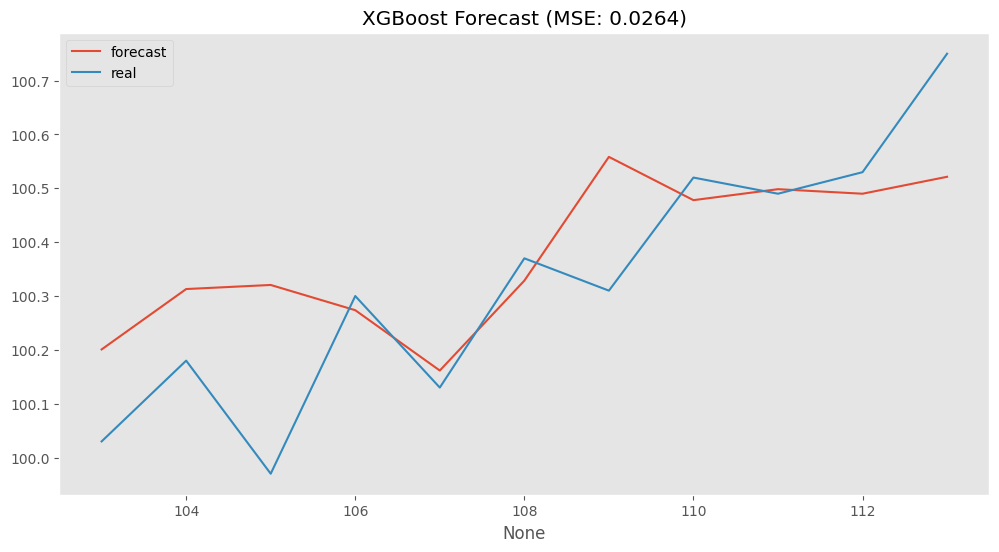

In [18]:
df_1 = df.drop(['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4',	'PCA_5',
               'PCA_6', 'PCA_7', 'PCA_8'], axis=1, inplace=False)
df_train = df_1[df_1['date'] < train_test_split_date].copy()
df_test = df_1[df_1['date'] >= train_test_split_date].copy()
y_train = df_train['inflation']
y_test = df_test['inflation']
df_train.drop(['inflation', 'date'], axis=1, inplace=True)
df_test.drop(['inflation', 'date'], axis=1, inplace=True)
X_train = df_train.copy()
X_test = df_test.copy()

# СДЕЛАЛ УСРЕДНЕНИЕ ШОКОВ
y_train[12] = (y_train[11] + y_train[13]) / 2
y_train[98] = (y_train[97] + y_train[99]) / 2
# Загрузка данных
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

y_train['ds'] = pd.date_range(
    start='2014-01-01', freq='ME', periods=len(y_train))
y_test['ds'] = pd.date_range(end='2023-08-31', freq='ME', periods=len(y_test))
# Создаем фичи для train и test
train_feats = create_features(y_train)
test_feats = create_features(y_test)
# Разделяем на X и y
y_train = train_feats['inflation']
X_train_infl = train_feats.drop(columns=['inflation', 'ds']).join(X_train)

y_test = test_feats['inflation']
X_test_infl = test_feats.drop(columns=['inflation', 'ds']).join(X_test)
# Настройка кросс-валидации для временных рядов
tscv = TimeSeriesSplit(n_splits=3)
# Параметры для подбора
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
# Инициализация и обучение модели
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(
    xgb_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_infl, y_train)
# Предсказание
xgb_pred = grid_search.predict(X_test_infl)
# Оценка качества
mse = mean_squared_error(y_test, xgb_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Best params: {grid_search.best_params_}")

# Визуализация
plt.figure(figsize=(12, 6))
sb.lineplot(x=y_test.index, y=xgb_pred, label='forecast')
y_test.plot(label='real')
plt.title(f"XGBoost Forecast (MSE: {mse:.4f})")
plt.legend()
plt.grid()
plt.show()

### С сглаживанием шоков с PCA


In [19]:
# СДЕЛАЛ УСРЕДНЕНИЕ ШОКОВ
y_train[12] = (y_train[11] + y_train[13]) / 2
y_train[98] = (y_train[97] + y_train[99]) / 2
# Загрузка данных
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

y_train['ds'] = pd.date_range(
    start='2014-01-01', freq='ME', periods=len(y_train))
y_test['ds'] = pd.date_range(end='2023-08-31', freq='ME', periods=len(y_test))
# Создаем фичи для train и test
train_feats = create_features(y_train)
test_feats = create_features(y_test)
# Разделяем на X и y
y_train = train_feats['inflation']
X_train_infl = train_feats.drop(columns=['inflation', 'ds']).join(X_train)

y_test = test_feats['inflation']
X_test_infl = test_feats.drop(columns=['inflation', 'ds']).join(X_test)
# Настройка кросс-валидации для временных рядов
tscv = TimeSeriesSplit(n_splits=3)
# Параметры для подбора
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
# Инициализация и обучение модели
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(
    xgb_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_infl, y_train)
# Предсказание
xgb_pred = grid_search.predict(X_test_infl)
# Оценка качества
mse = mean_squared_error(y_test, xgb_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Best params: {grid_search.best_params_}")

# Визуализация
plt.figure(figsize=(12, 6))
sb.lineplot(x=y_test.index, y=xgb_pred, label='forecast')
y_test.plot(label='real')
plt.title(f"XGBoost Forecast (MSE: {mse:.4f})")
plt.legend()
plt.grid()
plt.show()

/var/folders/r7/t8m59hld1hb_kbs6vxdb07vm0000gn/T/ipykernel_44588/2554253586.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train[98] = (y_train[97] + y_train[99]) / 2


Mean Squared Error: 0.0150
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
